# Section 8. Numerical results

## Section 8.3. Convergence outside the critical window

In this final section, we compare the empirically computed probability and our theoretical predictions for the range $p = \lambda / n$ for different $\lambda \neq 1$.

We need to construct 18 plots corresponding to a cartesian product of $3 \times 3 \times 2$ different cases:
* DAGs, elementary digraphs, and digraphs with 1 complex bicyclic component
* MD, D and SD models
* subcritical and supercritical case

In [1]:
import sys
import sympy as sp

print("Python version", sys.version)
print("Sympy version", sp.__version__)

import matplotlib
import numpy
import scipy
import tqdm as tqdm_lib

print("Matplotlib version", matplotlib.__version__)
print("Numpy version", numpy.__version__)
print("Scipy version", scipy.__version__)

### FLINT is necessary for this section
print("FLINT version = 2.8.4")
print("ARB version = 2.22.1")

### TQDM is the progress bar
print("tqdm version", tqdm_lib.__version__)


from datetime import date

print("Today:", date.today())

Python version 3.9.10 (main, Jan 15 2022, 11:48:00) 
[Clang 13.0.0 (clang-1300.0.29.3)]
Sympy version 1.10.1
Matplotlib version 3.5.1
Numpy version 1.22.3
Scipy version 1.8.0
FLINT version = 2.8.4
ARB version = 2.22.1
tqdm version 4.64.0
Today: 2022-04-07


In [2]:
%load_ext autoreload
%autoreload 2

# Specify the local path for the modules
import sys
import os.path as osp
sys.path.append(osp.join(osp.abspath(''), '..', 'lib'))

In [3]:
import flint
from flint import arb

exp = arb.exp
log = arb.log

from arb_utils import QQ
from arb_utils import p_dag, p_elem, p_1_bicyclic, p_1_pure_bicyclic
from arb_utils import alpha, beta, gamma2, sigma2, sigma_r, omega_elem, omega_r
from arb_utils import p_elem_D, p_elem_SD, p_1_bicyclic_D, p_1_bicyclic_SD
from arb_utils import p_dag_D, p_dag_SD

In [4]:
from scipy import special

ai_zero = special.ai_zeros(1)[0][0]
ai_prime_of_aj = special.ai_zeros(1)[3][0]
ai_prime_zero = special.ai_zeros(1)[1][0]
ai_of_aj_prime = special.ai_zeros(1)[2][0]

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

from tqdm import tqdm

import numpy as np

In [6]:
from matplotlib import cm  # colormaps

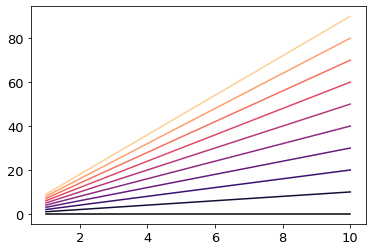

In [7]:
### cm.magma colormap is used in the paper

for i in range(10):
    plt.plot(np.linspace(1,10), i*np.linspace(1,10), c=cm.magma(i/10))

In [8]:
import matplotlib as mpl

In [9]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Borrowed from
    https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [10]:
########### SETTING THE EXPERIMENTAL INPUTS #################################

In [11]:
n_values = [1000, 1500, 2000, 2500, 3000, 5000]

In [12]:
lam_values_subcritical = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
lam_values_supercritical = [10, 7.5, 6, 5, 4, 3, 2, 1.5]

lam_values = lam_values_subcritical + lam_values_supercritical

In [13]:
######################## NEW NOTEBOOK STARTS HERE ###########################

##### PLOT DESIGN: DISTANCE FROM 1 RESCALED BY n^{gamma} ####################

In [14]:
###### UTILITY FUNCTION: GENERATE DATA ARRAY AND SAVE TO VARIABLE ###########

def gen_data(
    lam_values,
    n_values,
    proba_function,
    subcritical_prediction,
    supercritical_prediction
):
    """
    Args:
        lam_values: array of lambda values
        n_values: array of n values
        proba_function(n, p): FLINT function of two arguments
        subcritical_prediction(lam, n) when lam < 1, FLINT arb function
        supercritical_prediction(lam, n) when lam > 1, FLINT arb function
        
    Returns:
         [[]] of ratios p_finite / p_asymptotical for each lam in lam_values
    """
    output = []
    for lam in lam_values:
        output.append([])
        for n in tqdm(n_values):
            flint.ctx.dps = int(n*1.5)

            # empirical probability
            p = proba_function(n, QQ(1, n) * lam)

            # theoretical prediction
            if lam < 1:
                th = subcritical_prediction(lam, n)
            else:
                th = supercritical_prediction(lam, n)

            output[-1].append(float(p / th))
    return output

In [15]:
###### UTILITY FUNCTION: PLOT DATA WITH RESCALED FACTOR ###########

def plot_data(
    data,
    lam_values,
    n_values,
    label=None,
    fn=None,
    sign_chg=False
):
    """Utility plotting function

    Args:
        data: ratios empirical/theoretical, [[]]
        lam_values: array of lambda values.
            it is assumed that all lambdas are either <1 or all are >1.
        n_values: array of n values
        
    Optional args:
        label: plot title
        fn: (pdf) filename for plot output
        sign_chg: detects a sign change in comparison of the ratio vs. 1
            if True, then (p_emp/p_th - 1) is considered to be positive
            if False, then (1 - p_emp/p_th) is considered to be positive        
    """
    
    cmap = truncate_colormap(cm.magma, minval=0.2, maxval=0.9)
    cmap_r = truncate_colormap(cm.magma_r, maxval=0.8, minval=0.1)
    
    plt.box(on=False)
    plt.grid(True, linestyle='--')
    plt.xlabel(r"$\log\, n$")
    
    if not sign_chg:        
        plt.ylabel(r"$\log \left[\dfrac{\mathbb{P}_{\mathsf{empirical}}}{\mathbb{P}_{\mathsf{theoretical}}} -1\right]$")
    else:
        plt.ylabel(r"$\log \left[1 - \dfrac{\mathbb{P}_{\mathsf{empirical}}}{\mathbb{P}_{\mathsf{theoretical}}}\right]$")

    for lam, idx in zip(lam_values, range(len(lam_values))):
        sign_fun = (
            lambda t: -t
            if sign_chg
            else t
        )
        X = [np.log(x) for x in n_values]
        
        Y = [
            np.log(sign_fun(x - 1))
            for x, i in zip(data[idx], range(len(n_values)))
        ]
        plt.plot(
            X, Y,
            label= r"$\lambda$ = "+str(lam),
            c=cmap(idx / (len(lam_values)-1)),
            linewidth=2
        )
                
    if label is not None:
        plt.title(label)
        
    # UNIFORM TICKS ON COLORBAR + TRUNCATED CMAP + CBAR TITLE
    
    bounds = [lam for lam in sorted(lam_values)]
    stretched_bounds = np.interp(np.linspace(0, 1, 257), np.linspace(0, 1, len(bounds)), bounds)

    # normalize stretched bound values
    norm = mpl.colors.BoundaryNorm(stretched_bounds, ncolors=256)

    sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=norm)
    sm.set_array([])
    cbar, = plt.colorbar(sm, ticks=bounds),
    cbar.ax.set_title(r"$\lambda$")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches = "tight")

# Multidigraph families

## DAGs

> time: 9 minutes

In [16]:
%%time

multi_dag_data = gen_data(
    lam_values,
    n_values,
    p_dag,
    lambda lam, n: 1 - lam,
    lambda lam, n: (
        gamma2(lam)
        * n**QQ(-1,3)
        * arb.exp(-alpha(lam)*n + ai_zero * beta(lam) * n**QQ(1,3))
    )
)

multi_dag_subcritical_data = multi_dag_data[:len(lam_values_subcritical)]
multi_dag_supercritical_data = multi_dag_data[len(lam_values_subcritical):]

100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.06s/it]

CPU times: user 8min 34s, sys: 10.3 s, total: 8min 44s
Wall time: 9min 6s


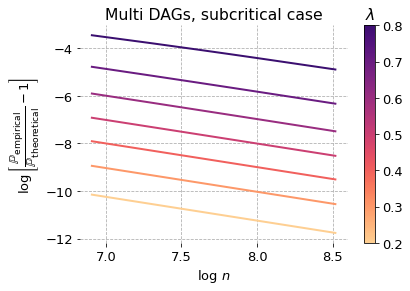

In [17]:
plot_data(
    multi_dag_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Multi DAGs, subcritical case",
    fn="m_dags_sub.pdf"
)

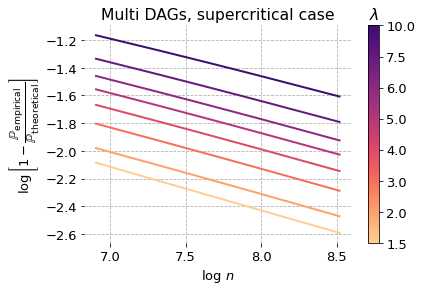

In [18]:
plot_data(
    multi_dag_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Multi DAGs, supercritical case",
    sign_chg=True,
    fn="m_dags_super.pdf"
)

## Elementary digraphs

> time: 18 minutes

In [19]:
%%time

multi_elem_data = gen_data(
    lam_values,
    n_values,
    p_elem,
    lambda lam, n: 1,
    lambda lam, n: (
        sigma2(lam)
        * arb.exp(-alpha(lam)*n + ai_prime_zero * beta(lam) * n**QQ(1,3))
    )
)

multi_elem_subcritical_data = multi_elem_data[:len(lam_values_subcritical)]
multi_elem_supercritical_data = multi_elem_data[len(lam_values_subcritical):]

100%|█████████████████████████████████████████████| 6/6 [01:14<00:00, 12.44s/it]

CPU times: user 16min 29s, sys: 40.1 s, total: 17min 9s
Wall time: 18min 4s


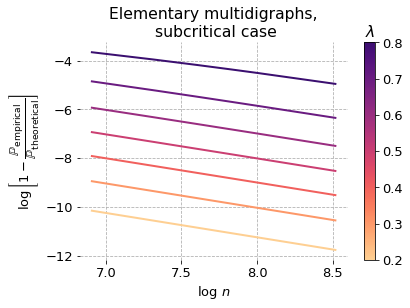

In [20]:
plot_data(
    multi_elem_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Elementary multidigraphs,\n subcritical case",
    sign_chg=True,
    fn="m_elem_sub.pdf"
)

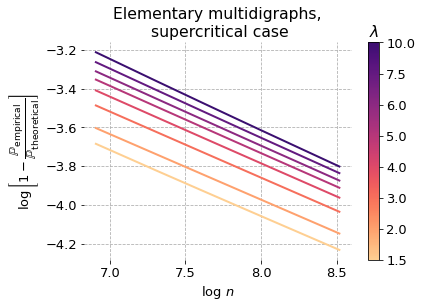

In [21]:
plot_data(
    multi_elem_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Elementary multidigraphs,\n supercritical case",
    sign_chg=True,
    fn="m_elem_super.pdf"
)

## One bicyclic component

In [ ]:
%%time

multi_bicyclic_data = gen_data(
    lam_values,
    n_values,
    p_1_bicyclic,
    lambda lam, n: (
        QQ(1, 2) # compensation factor
        * n**(-1)
        * (
            (lam / (1 - lam))**3
            + (lam / (1 - lam))**2
        )
    ),
    lambda lam, n: (
        QQ(1, 2) # compensation factor
        * n ** QQ(1, 3)
        * sigma_r(lam, 1)
        * arb.exp(-alpha(lam)*n + ai_prime_zero * beta(lam) * n**QQ(1,3))
    )
)

multi_bicyclic_subcritical_data = multi_bicyclic_data[:len(lam_values_subcritical)]
multi_bicyclic_supercritical_data = multi_bicyclic_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    multi_bicyclic_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Multidigraphs with one bicyclic complex\n component, subcritical case",
    sign_chg=True,
    fn="m_bicyclic_sub.pdf"
)

In [ ]:
plot_data(
    multi_bicyclic_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Multidigraphs with one bicyclic complex\n component, supercritical case",
    fn="m_bicyclic_super.pdf"
)

# Simple digraphs D(n, p) and SD(n, p)

## Simple DAGs D(n,p)

In [ ]:
%%time

simple_d_dag_data = gen_data(
    lam_values,
    n_values,
    p_dag_D,
    lambda lam, n: (1 - lam) * exp(arb(lam)),
    lambda lam, n: (
        arb.exp(-lam**2/4 + 3*lam/2 - QQ(1,4))
        * n**QQ(-1,3)
        * gamma2(lam)
        * arb.exp(-alpha(lam)*n + ai_zero * beta(lam) * n**QQ(1,3))
    )
)

simple_d_dag_subcritical_data = simple_d_dag_data[:len(lam_values_subcritical)]
simple_d_dag_supercritical_data = simple_d_dag_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    simple_d_dag_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Simple DAGs $\mathbb{D}(n,p)$,\n subcritical case",
    fn="d_dags_sub.pdf"
)

In [ ]:
plot_data(
    simple_d_dag_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Simple DAGs $\mathbb{D}(n,p)$,\n supercritical case",
    fn="d_dags_super.pdf",
    sign_chg=True
)

## Simple DAGs SD(n,p)

In [ ]:
%%time

simple_sd_dag_data = gen_data(
    lam_values,
    n_values,
    p_dag_SD,
    lambda lam, n: (1 - lam) * exp(arb(lam) + arb(lam)**2/2),
    lambda lam, n: (
        arb.exp(-lam**2/4 + 5*lam/2 - QQ(3,4))
        * n**QQ(-1,3)
        * gamma2(lam)
        * arb.exp(-alpha(lam)*n + ai_zero * beta(lam) * n**QQ(1,3))
    )
)

simple_sd_dag_subcritical_data = simple_sd_dag_data[:len(lam_values_subcritical)]
simple_sd_dag_supercritical_data = simple_sd_dag_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    simple_sd_dag_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Simple DAGs $\mathbb{SD}(n,p)$,\n subcritical case",
    fn="sd_dags_sub.pdf"
)

In [ ]:
plot_data(
    simple_sd_dag_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Simple DAGs $\mathbb{SD}(n,p)$,\n supercritical case",
    fn="sd_dags_super.pdf",
    sign_chg=True
)

## Elementary D(n, p)

In [ ]:
%%time

simple_d_elem_data = gen_data(
    lam_values,
    n_values,
    p_elem_D,
    lambda lam, n: 1,
    lambda lam, n: (
        omega_elem(lam)
        * arb.exp(-alpha(lam)*n + ai_prime_zero * beta(lam) * n**QQ(1,3))
    )
)

simple_d_elem_subcritical_data = simple_d_elem_data[:len(lam_values_subcritical)]
simple_d_elem_supercritical_data = simple_d_elem_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    simple_d_elem_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Elementary digraphs $\mathbb{D}(n,p)$,\n subcritical case",
    fn="d_elem_sub.pdf",
    sign_chg=True
)

In [ ]:
plot_data(
    simple_d_elem_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Elementary digraphs $\mathbb{D}(n,p)$,\n supercritical case",
    fn="d_elem_super.pdf",
    sign_chg=False
)

## Elementary SD(n, p)

In [ ]:
%%time

simple_sd_elem_data = gen_data(
    lam_values,
    n_values,
    p_elem_SD,
    lambda lam, n: 1,
    lambda lam, n: (
        omega_elem(lam)
        * arb.exp(-alpha(lam)*n + ai_prime_zero * beta(lam) * n**QQ(1,3))
    )
)

simple_sd_elem_subcritical_data = simple_sd_elem_data[:len(lam_values_subcritical)]
simple_sd_elem_supercritical_data = simple_sd_elem_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    simple_sd_elem_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Elementary digraphs $\mathbb{SD}(n,p)$,\n subcritical case",
    fn="sd_elem_sub.pdf",
    sign_chg=True
)

In [ ]:
plot_data(
    simple_sd_elem_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Elementary digraphs $\mathbb{SD}(n,p)$,\n supercritical case",
    fn="sd_elem_super.pdf",
    sign_chg=False
)

## One bicyclic component, D(n,p)

In [ ]:
%%time

simple_d_bicyclic_data = gen_data(
    lam_values,
    n_values,
    p_1_bicyclic_D,
    lambda lam, n: (
        QQ(1, 2) # compensation factor
        * n**(-1)
        * lam * (
            (lam / (1 - lam))**3 * (2-lam)
            + (lam / (1 - lam))**2 * lam
        )
    ),
    lambda lam, n: (
        QQ(1, 2) # compensation factor
        * n ** QQ(1, 3)
        * omega_r(lam, 1)
        * arb.exp(-alpha(lam)*n + ai_prime_zero * beta(lam) * n**QQ(1,3))
    )
)

simple_d_bicyclic_subcritical_data = simple_d_bicyclic_data[:len(lam_values_subcritical)]
simple_d_bicyclic_supercritical_data = simple_d_bicyclic_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    simple_d_bicyclic_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Digraphs $\mathbb{D}(n,p)$ with one bicyclic complex\n component, subcritical case",
    sign_chg=True,
    fn="d_bicyclic_sub.pdf"
)

In [ ]:
plot_data(
    simple_d_bicyclic_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Digraphs $\mathbb{D}(n,p)$ with one bicyclic complex\n component, supercritical case",
    fn="d_bicyclic_super.pdf"
)

## One bicyclic component, SD(n,p)

In [ ]:
%%time

simple_sd_bicyclic_data = gen_data(
    lam_values,
    n_values,
    p_1_bicyclic_SD,
    lambda lam, n: (
        QQ(1, 2) # compensation factor
        * n**(-1)
        * lam**2 * (
            (lam / (1 - lam))**3 * (3-2*lam)
            + (lam / (1 - lam))**2 * lam**2
        )
    ),
    lambda lam, n: (
        QQ(1, 2) # compensation factor
        * n ** QQ(1, 3)
        * omega_r(lam, 1)
        * arb.exp(-alpha(lam)*n + ai_prime_zero * beta(lam) * n**QQ(1,3))
    )
)

simple_sd_bicyclic_subcritical_data = simple_sd_bicyclic_data[:len(lam_values_subcritical)]
simple_sd_bicyclic_supercritical_data = simple_sd_bicyclic_data[len(lam_values_subcritical):]

In [ ]:
plot_data(
    simple_sd_bicyclic_subcritical_data,
    lam_values_subcritical,
    n_values,
    label="Digraphs $\mathbb{SD}(n,p)$ with one bicyclic complex\n component, subcritical case",
    sign_chg=True,
    fn="sd_bicyclic_sub.pdf"
)

In [ ]:
plot_data(
    simple_sd_bicyclic_supercritical_data,
    lam_values_supercritical,
    n_values,
    label="Digraphs $\mathbb{SD}(n,p)$ with one bicyclic complex\n component, supercritical case",
    fn="sd_bicyclic_super.pdf"
)

This concludes the paper. 